In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy as sp
import seaborn as sns
from scipy import stats
import bayes_toolbox.glm as bg

plt.rcParams.update({'font.size': 20}) #set default figure size

sns.set_theme("talk")
sns.set_style("ticks")
# sns.set(font_scale=2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv("../results/ige_ege_nofb.csv")
df["adaptation"] = np.nan
df["total error"] = np.nan
df.columns

Index(['si', 'SN', 'id', 'tester', 'TN', 'move_cycle', 'hX', 'hY', 'rot_hX',
       'rot_hY', 'rotation', 'tgt_jump', 'hand_max_dist', 'radvelmax', 'tgtX',
       'tgtY', 'rot_hand_theta', 'theta_maxradv', 'raw_ep_hand_ang', 'tgt_ang',
       'tgt_dist', 'fbi', 'MT', 'RT', 'ST', 'adaptation', 'total error'],
      dtype='object')

In [3]:
df.head()

,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,theta_maxradv,raw_ep_hand_ang,tgt_ang,tgt_dist,fbi,MT,RT,ST,adaptation,total error
0,1,1,01_i,s,1,1,1.016301,86.248669,0.0,0.0,...,1.904985,90.675107,90,90,1,0.615282,1.014866,7.633636,NaN,NaN
1,1,1,01_i,s,2,2,5.536301,86.258669,0.0,0.0,...,2.936599,93.672352,90,90,1,0.231682,0.511399,2.075607,NaN,NaN
2,1,1,01_i,s,3,3,10.556301,62.868669,0.0,0.0,...,11.363841,99.531641,90,90,1,0.215753,0.333589,1.522229,NaN,NaN
3,1,1,01_i,s,4,4,3.616301,82.738669,0.0,0.0,...,3.730118,92.502663,90,90,1,0.231725,0.263689,1.460292,NaN,NaN
4,1,1,01_i,s,5,5,1.816301,104.148669,0.0,0.0,...,1.664402,90.999109,90,90,1,0.223751,0.894948,1.364413,NaN,NaN


In [4]:
# Outlier removal
z_thresh = 4

# z-score hand angle data
df["theta_maxradv_z"] = df.groupby("SN")["theta_maxradv"].transform(stats.zscore)

# Create outlier column
df["theta_maxradv_outlier"] = np.abs(df["theta_maxradv_z"]) > z_thresh

# Calculate within-subject mean using non-outlier trials only
df["theta_maxradv_mean"] = df[np.abs(df["theta_maxradv_z"]) <= z_thresh].groupby("SN")["theta_maxradv"].transform(np.mean)

# Replace outliers with within-subject mean values
df["theta_maxradv_mean"] = df.groupby("SN")["theta_maxradv_mean"].transform(lambda x: x.fillna(np.nanmean(x)))

# Create final column with "cleaned" hand angles
df["theta_maxradv_clean"] = np.where(np.abs(df["theta_maxradv_z"]) > z_thresh,
                                     df["theta_maxradv_mean"],
                                     df["theta_maxradv"])

# df[np.abs(df["theta_maxradv_z"]) > z_thresh].sample(10)

### Writing custom-function for outlier removal

In [5]:
# def replace_outliers(z_thresh, var, subj_id):
    
#     # z-score var
#     df["var" + "_z"] = df.groupby(subj_id)[var].transform(stats.zscore)
    
#     # Create outlier column
#     df["var" + "_outlier"] = np.abs(df["var_z"]) > z_thresh

#     # Calculate within-subject mean using non-outlier trials only
#     df["var" + "_mean"] = df[np.abs(df["var_z"]) <= z_thresh].groupby("subj_id")["var"].transform(np.mean)

#     # Replace outliers with within-subject mean values
#     df["var_mean"] = df.groupby("subj_id")["var_mean"].transform(lambda x: x.fillna(np.nanmean(x)))

#     # Create final column with "cleaned" hand angles
#     df["var" + "_clean"] = np.where(np.abs(df["var_z"]) > z_thresh,
#                                      df["var_mean"],
#                                      df["var"])
    
#     return df["var_z"]

In [6]:
# View sample of rows to confirm hand angle varies by subject
df[df["theta_maxradv_z"] > z_thresh].sample()

# Count number of outliers per participant
df.groupby("SN")["theta_maxradv_outlier"].sum()

# # Check by again printing a sample of outlier rows
# df[df["theta_maxradv_z"] > z_thresh].sample()

SN
1    2
2    0
Name: theta_maxradv_outlier, dtype: int64

In [7]:
mask = (df["TN"] >= 31) & (df["TN"] <= 70)
df["movement_var"] = df[mask].groupby("SN")["theta_maxradv_clean"].transform(np.std)
# df.head(15)
df[mask]

,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,MT,RT,ST,adaptation,total error,theta_maxradv_z,theta_maxradv_outlier,theta_maxradv_mean,theta_maxradv_clean,movement_var
30,1,1,01_i,s,31,31,-0.003699,93.168669,0.0,0.0,...,0.279672,0.279653,1.232578,NaN,NaN,-0.565656,False,0.459372,-0.760583,1.704532
31,1,1,01_i,s,32,32,-1.093699,104.908669,0.0,0.0,...,0.279679,0.325614,1.430320,NaN,NaN,-0.692887,False,0.459372,-1.035416,1.704532
32,1,1,01_i,s,33,33,-2.763699,81.988669,0.0,0.0,...,0.259690,0.333609,0.970867,NaN,NaN,-1.383047,False,0.459372,-2.526243,1.704532
33,1,1,01_i,s,34,34,-0.083699,79.518669,0.0,0.0,...,0.227740,0.249702,1.326460,NaN,NaN,-1.014691,False,0.459372,-1.730549,1.704532
34,1,1,01_i,s,35,35,-3.073699,87.298669,0.0,0.0,...,0.219736,0.251701,1.032784,NaN,NaN,-0.898998,False,0.459372,-1.480639,1.704532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,2,2,02_i,s,66,66,0.026301,88.818669,0.0,0.0,...,0.399575,0.237729,1.174747,NaN,NaN,-0.236095,False,0.292840,-0.188832,1.468461
1136,2,2,02_i,s,67,67,-2.353699,85.208669,0.0,0.0,...,0.435530,0.223761,0.964971,NaN,NaN,-1.415185,False,0.292840,-2.594371,1.468461
1137,2,2,02_i,s,68,68,0.556301,87.688669,0.0,0.0,...,0.391568,0.187785,1.164718,NaN,NaN,-0.050219,False,0.292840,0.190385,1.468461
1138,2,2,02_i,s,69,69,-3.813699,87.078669,0.0,0.0,...,0.379565,0.227742,1.168739,NaN,NaN,-0.972376,False,0.292840,-1.690968,1.468461


In [8]:
# # Find outliers and remove based on hard threshold
# outlier_idx = np.where(np.abs(df.theta_maxradv) >= 45)
# outlier_idx = np.asarray(outlier_idx).flatten()
# print(f'Total number of outliers: ', len(outlier_idx))
# cols = ["rotation", "rot_hand_theta", "theta_maxradv", "raw_ep_hand_ang", "MT", "RT"]
# df.loc[outlier_idx, cols] = np.nan


In [9]:
# # For regressing adaptation over total error at each level of ege:
# # 1) Split data into groups defined by ege;
# # 2) Bin data for each perturbation level into quintiles
# df_adapt["bin_vis"] = df_adapt.groupby("ege")["total_err_vis"].transform(lambda x: pd.qcut(x, 5, labels=[1, 2, 3, 4, 5]))
# df_adapt["bin_ege"] = df_adapt.groupby("ege")["total_err_ege"].transform(lambda x: pd.qcut(x, 5, labels=[1, 2, 3, 4, 5]))

# # Create data frames of binned data
# df_bin_vis = df_adapt.groupby(["ege", "bin_vis"])[["total_err_vis", "adapt_vis"]].mean()
# df_bin_vis.reset_index(inplace=True) # flatten data frame for easier indexing

# df_bin_ege = df_adapt.groupby(["ege", "bin_ege"])[["total_err_ege", "adapt_ege"]].mean()
# df_bin_ege.reset_index(inplace=True)

In [10]:
# training = df.loc[df["TN"] >= training_start, :].reset_index()
# training.loc[1:, "adaptation"] = [training.loc[i + 1, "theta_maxradv"] - training.loc[i - 1, "theta_maxradv"] for i in range(1, len(training)-1)]

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


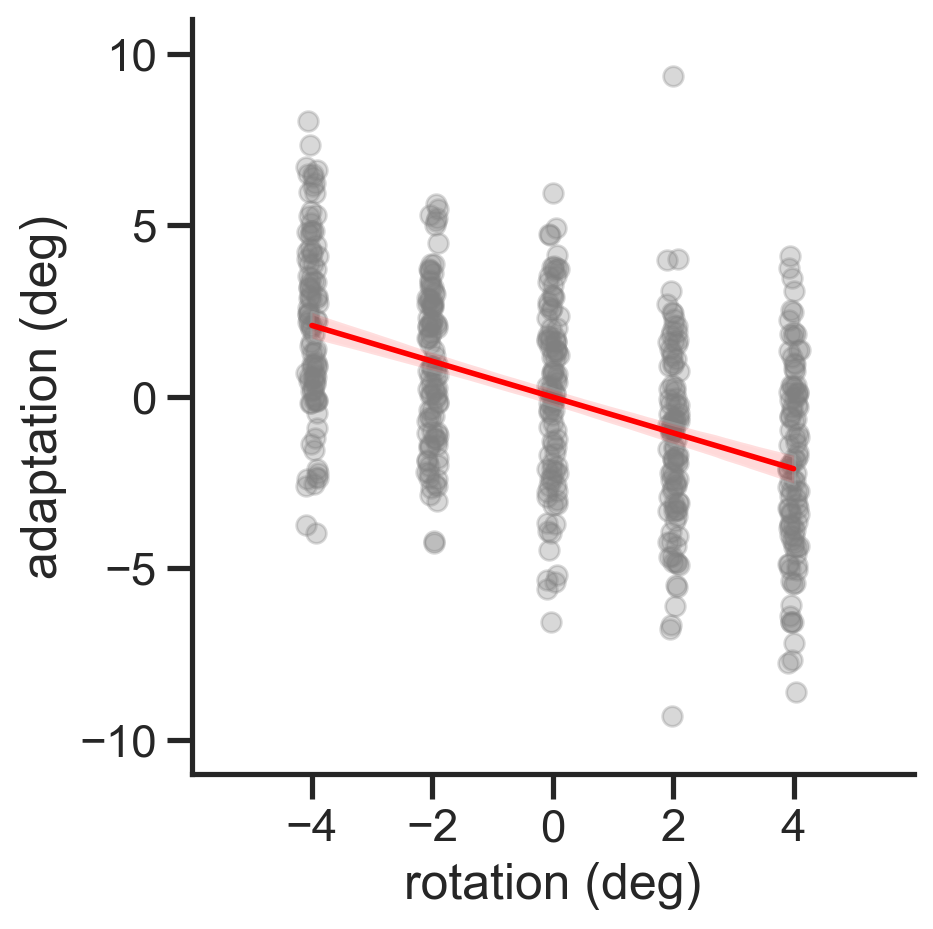

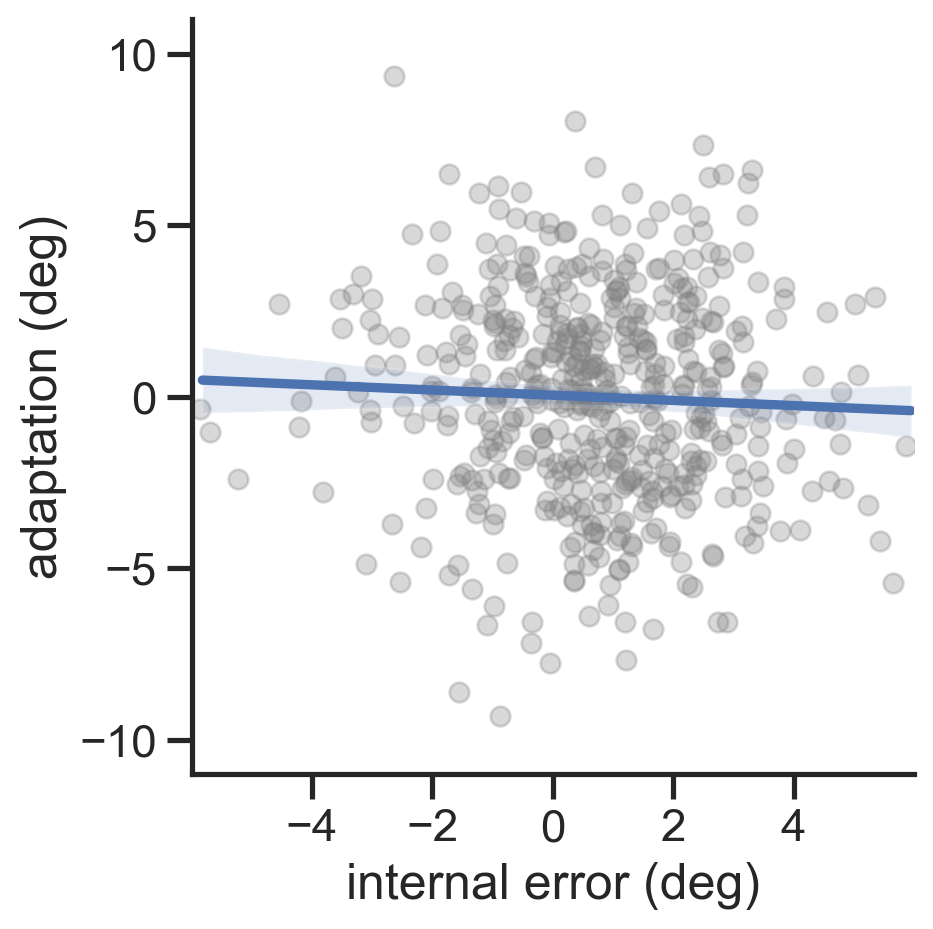

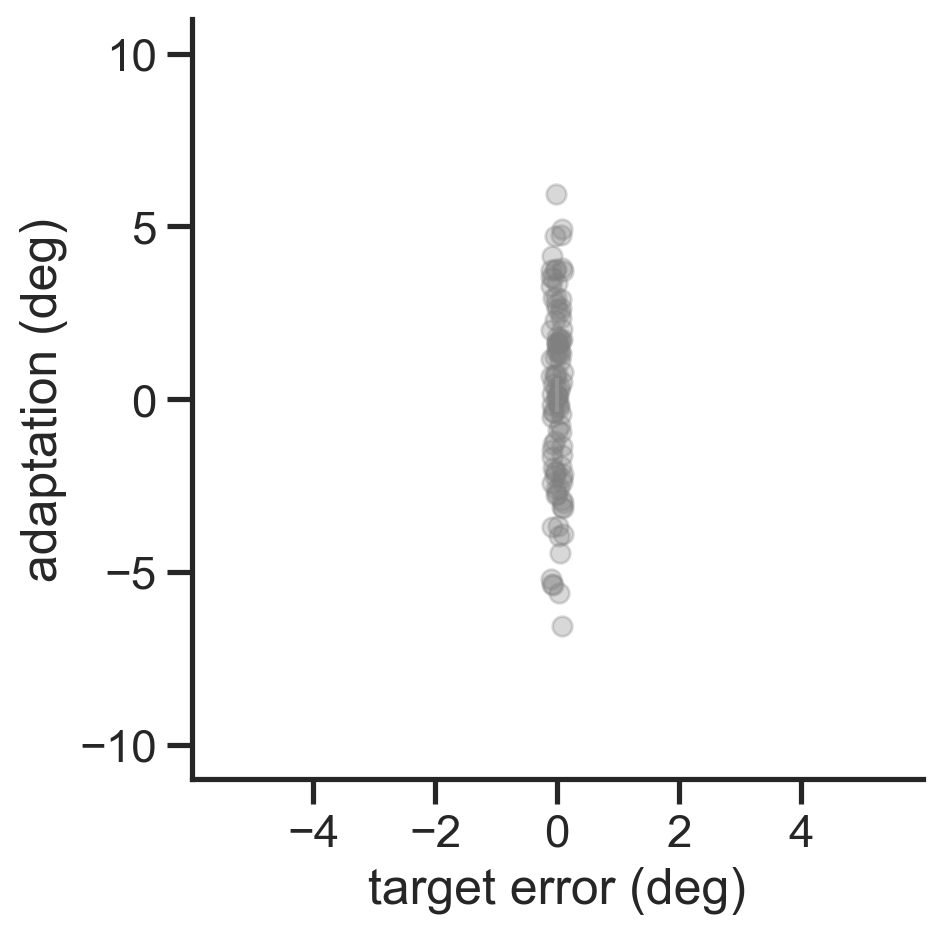

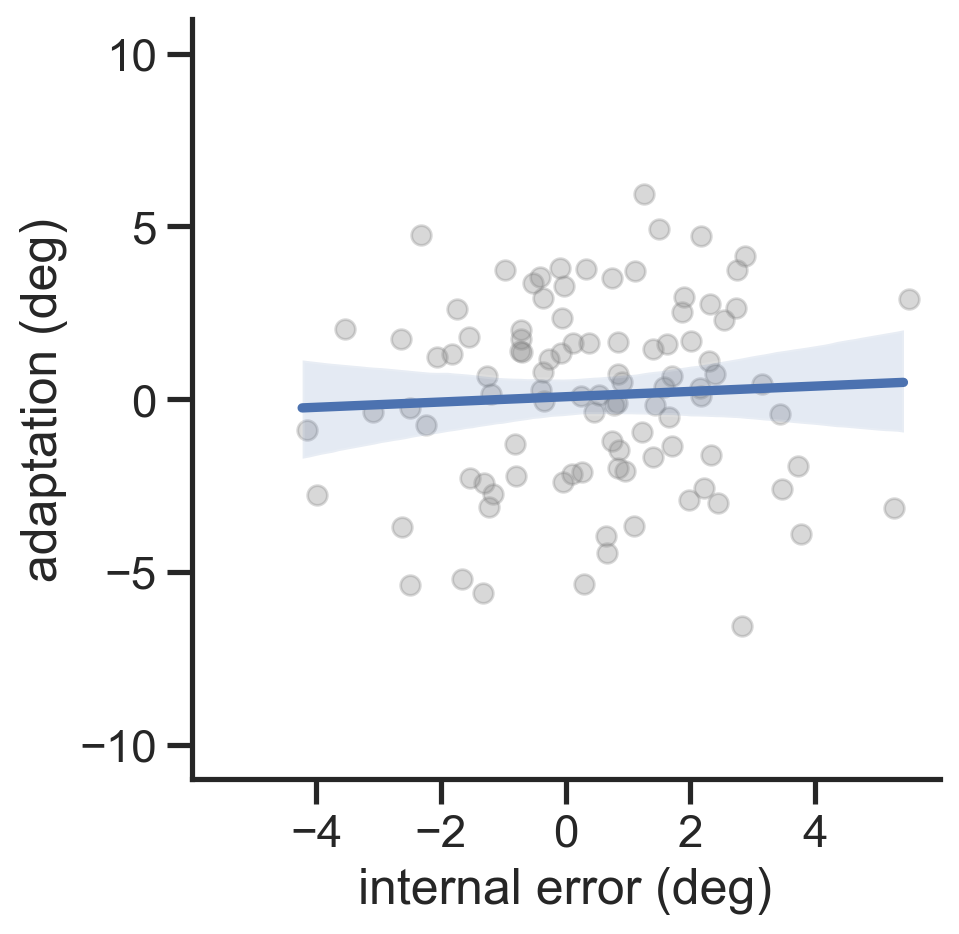

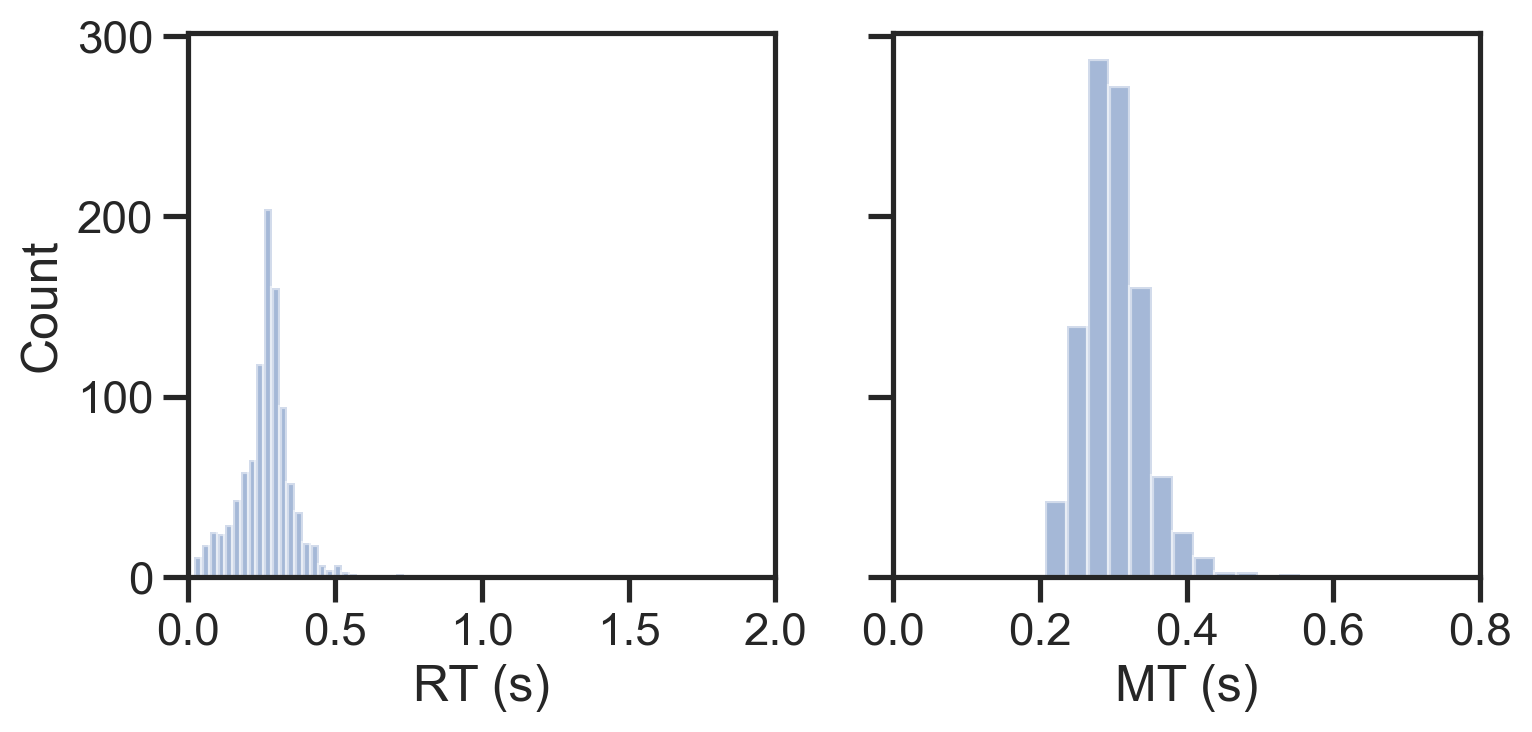

Adaptation to ege-vmr has slope of -0.5219326153313059, p-val of 3.157818925703266e-31.
Adaptation to ige on rotation trials has slope of -0.07561327667061678, p-val of 0.30074678204047683.


/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


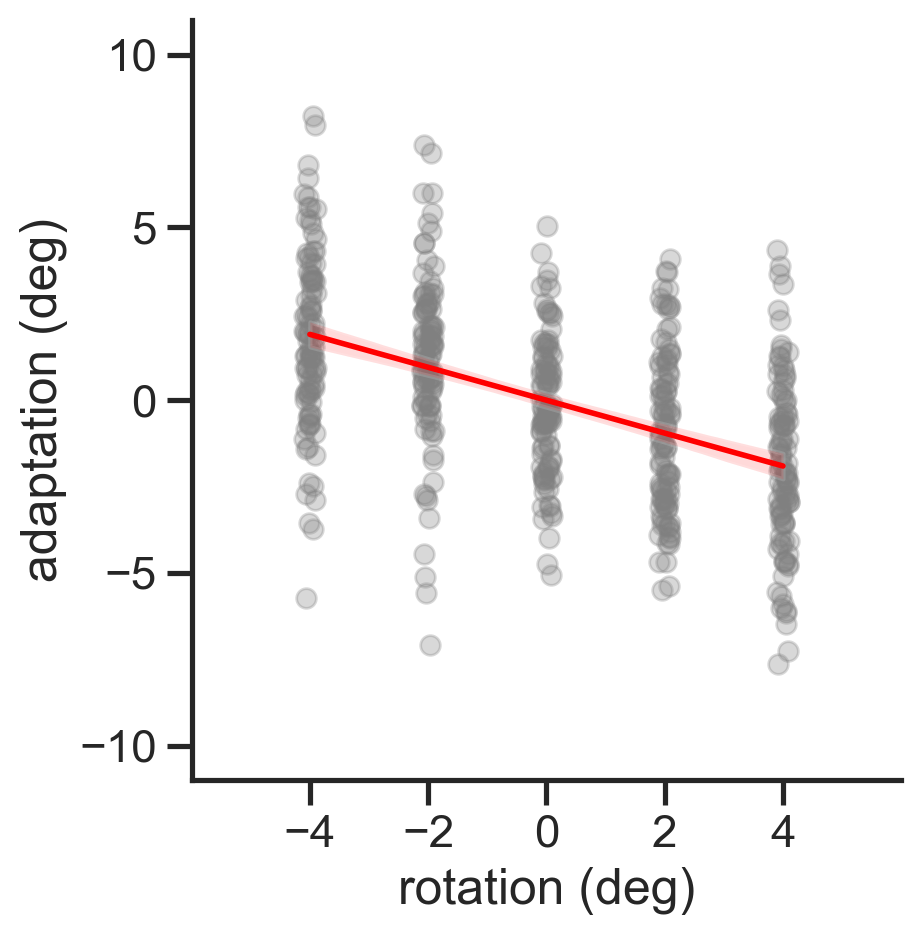

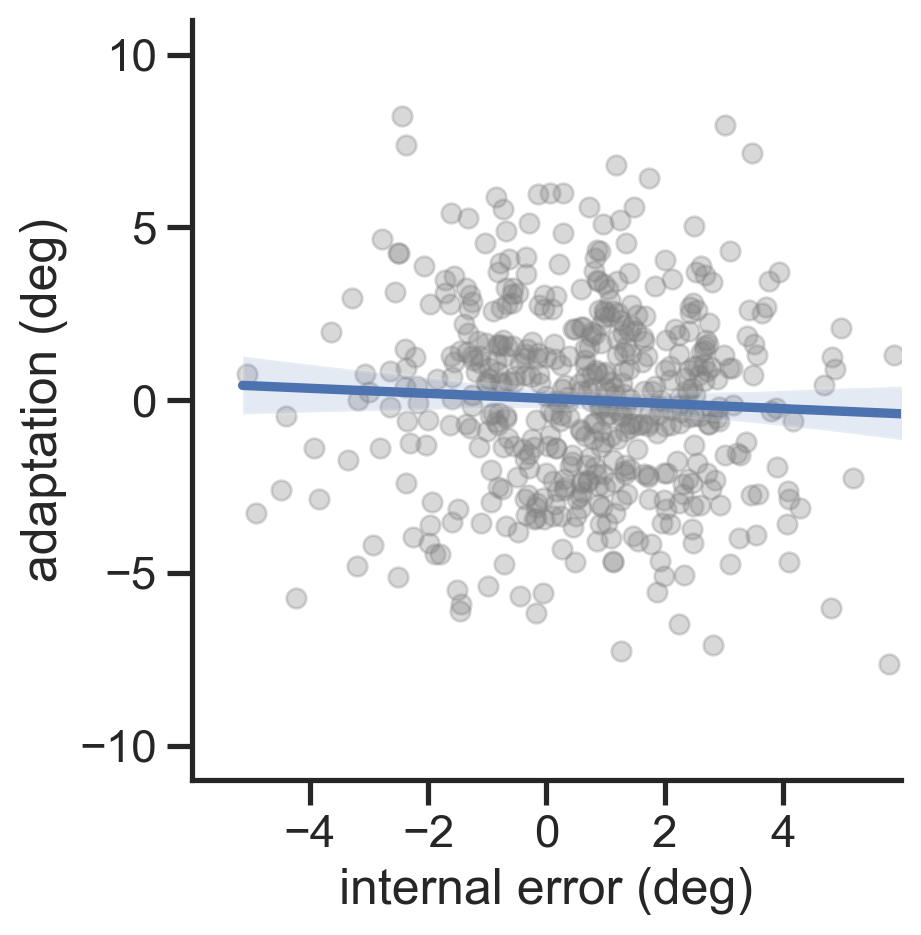

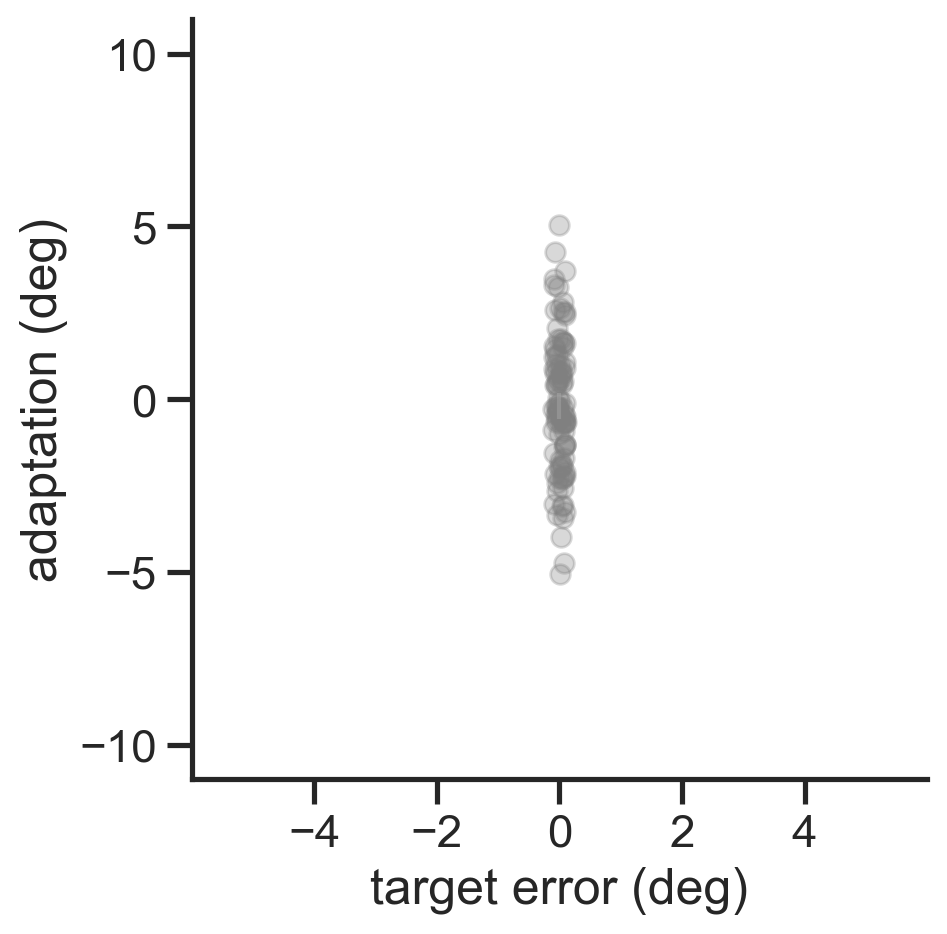

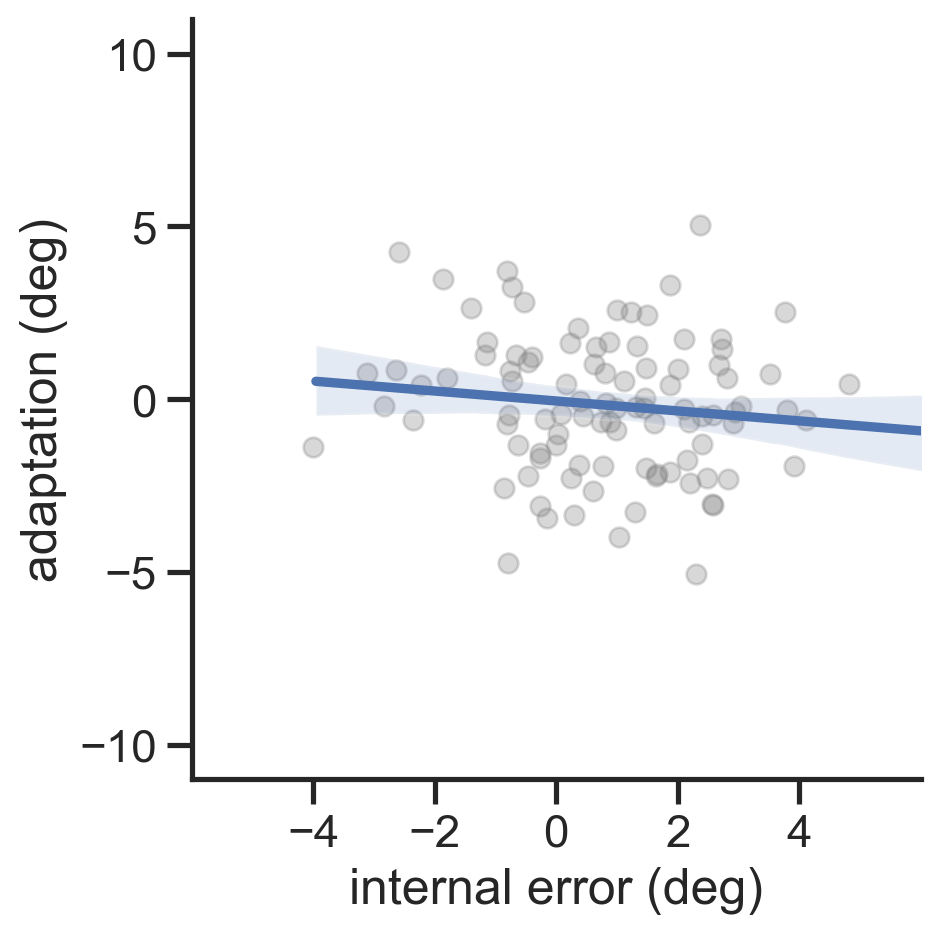

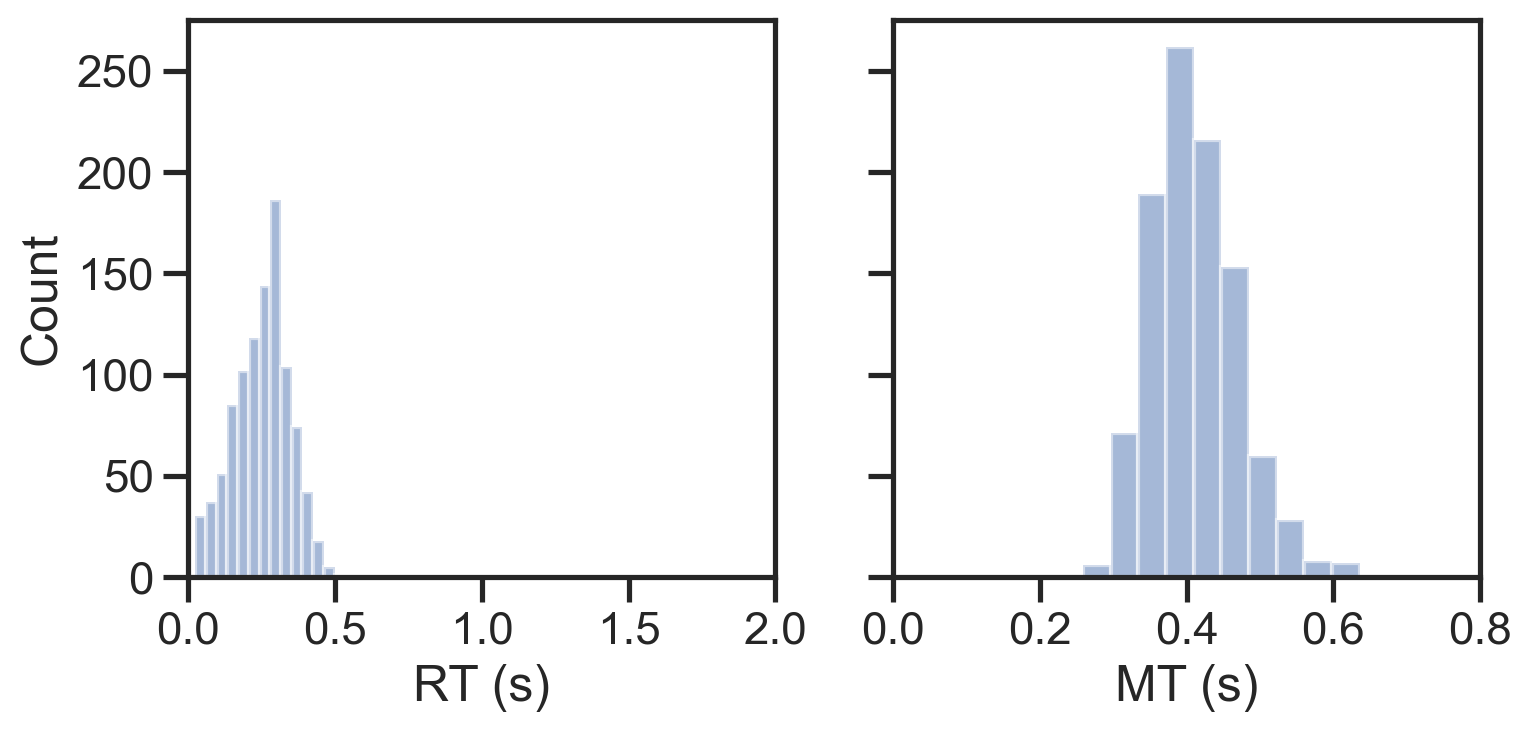

Adaptation to ege-vmr has slope of -0.47632021355355386, p-val of 2.9486752022764983e-32.
Adaptation to ige on rotation trials has slope of -0.07374485698918243, p-val of 0.2622253758705353.


In [11]:
# Choose whether to visualize all data or only adaptation trials preceded by no fb
truncate = False

adapt_rotation = pd.DataFrame()
adapt_jump = pd.DataFrame()
sigma_motor_bsl = []
sigma_motor_train = []
sigma_v_train = []

for s in df["id"].unique():
    # Create subject-specific data frame
    subj = df[df["id"] == s].reset_index(drop=True)
    
    # Calculate baseline variability
    sigma_motor_bsl.append(subj.loc[20:70, "theta_maxradv_clean"].std())
    
    # Create truncated data frame without baseline trials
    training_start = 70
    subj_train = subj.iloc[training_start - 1:, :].reset_index(drop=True)
    pert_idx = np.arange(1, len(subj_train), 2)
    
    # Loop through trials to get adaptation index
    for i in np.arange(1, len(subj_train), 2):
        subj_train.loc[i, "adaptation"] = subj_train.loc[i + 1, "theta_maxradv_clean"] - subj_train.loc[i - 1, "theta_maxradv_clean"] 
        subj_train.loc[i, "total error"] = subj_train.loc[i, "theta_maxradv_clean"] + subj_train.loc[i, "rotation"]
    
    # Calculate motor and vis fb variability during training
    sigma_motor_train.append(subj_train["theta_maxradv_clean"].std())
    vis_fb_idx = subj_train["fbi"] == 1
    sigma_v_train.append(subj_train.loc[vis_fb_idx, "total error"].std())
    
    subj_adapt = subj_train.loc[pert_idx, :].reset_index()
    subj_adapt["tgt_error"] = subj_adapt["tgt_jump"] * -1
    
    # Pick out trials preceded by no-feedback null trial
    nofb_idx = np.zeros(len(subj_train), dtype=bool)
    nofb_idx[1:] = subj_train.loc[0:len(subj_train) - 2, "fbi"] == 0  # .loc slicing includes start and stop index
    
    # Insert zero at start of array to index pert trials with preceding no-fb trial
    nofb_triplet_idx = nofb_idx
    subj_adapt_nofb = subj_train.loc[nofb_triplet_idx, :].reset_index()
    subj_adapt_nofb["tgt_error"] = subj_adapt_nofb["tgt_jump"] * -1
    
    # Create separate vmr and target jump data frames
    vmr = subj_adapt.loc[subj_adapt["tgt_jump"] == 0, :]  # Includes 0d rotation
    vmr_nofb = subj_adapt_nofb.loc[subj_adapt_nofb["tgt_jump"] == 0, :]
    mask_jump = (subj_adapt["tgt_jump"] != 0) | ((subj_adapt["tgt_jump"] == 0) & (subj_adapt["rotation"] == 0))
    mask_jump_nofb = (subj_adapt_nofb["tgt_jump"] != 0) | ((subj_adapt_nofb["tgt_jump"] == 0) & (subj_adapt_nofb["rotation"] == 0))
    jump = subj_adapt[mask_jump]
    jump_nofb = subj_adapt_nofb[mask_jump_nofb]
    
    # Concatenate individual subject data frames
    adapt_rotation = pd.concat([adapt_rotation, vmr], ignore_index=True)
    adapt_jump = pd.concat([adapt_jump, jump], ignore_index=True)
    
    # Assign correct data frame for visualization
    if truncate == True:
        df_vmr = vmr_nofb.copy()
        df_jump = jump_nofb.copy()
    else:
        df_vmr = vmr.copy()
        df_jump = jump.copy()
    
    # Plot data for adapt vs vmr-ege
    g = sns.lmplot(data=df_vmr, x="rotation", y="adaptation", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=50), 
               line_kws=dict(linewidth=2, color='red'), ci=95)
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
      xlabel="rotation (deg)", ylabel="adaptation (deg)")
    # g.savefig("adapt-vmr-ege.png", dpi="figure")
    
    # Plot data for adapt vs ige
    g = sns.lmplot(data=df_vmr, x="theta_maxradv_clean", y="adaptation", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=50), ci=95)
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
      xlabel="internal error (deg)", ylabel="adaptation (deg)");
    # g.savefig("adapt-vmr-ige.png")

    # Plot data for adapt vs tgt_jump-ege
    g = sns.lmplot(data=df_jump, x="tgt_error", y="adaptation", x_jitter=0.1, 
                   scatter_kws=dict(alpha=0.3, color='gray', s=50), 
                   line_kws=dict(linewidth=2, color='red'), ci=95)
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
          xlabel="target error (deg)", ylabel="adaptation (deg)");
    # g.savefig("adapt-target-jump-ege.png")

    # Plot data for adapt vs ige
    g = sns.lmplot(data=df_jump, x="theta_maxradv_clean", y="adaptation", x_jitter=0.1, 
                   scatter_kws=dict(alpha=0.3, color='gray', s=50))
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
          xlabel="internal error (deg)", ylabel="adaptation (deg)");
    # g.savefig("adapt-target-jump-ige.png")

    # Plot RTs and MTs
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True, layout="tight")
    ax[0].hist(subj_train["RT"], alpha=0.5, bins=40)
    ax[0].set(xlabel="RT (s)", ylabel="Count", xlim=[0, 2])
    ax[1].hist(subj_train["MT"], alpha=0.5, bins=12)
    ax[1].set(xlabel="MT (s)", xlim=[0, 0.8])
    plt.show()
    
    # Print out statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(vmr["rotation"], vmr["adaptation"])
    print(f"Adaptation to ege-vmr has slope of {slope}, p-val of {p_value}.")

    slope, intercept, r_value, p_value, std_err = stats.linregress(vmr["theta_maxradv"], vmr["adaptation"])
    print(f"Adaptation to ige on rotation trials has slope of {slope}, p-val of {p_value}.")

#     slope, intercept, r_value, p_value, std_err = stats.linregress(jump["tgt_error"], jump["adaptation"])
#     print(f"Adaptation to ege-target jump has slope of {slope}, p-val of {p_value}.")

#     slope, intercept, r_value, p_value, std_err = stats.linregress(jump["theta_maxradv"], jump["adaptation"])
#     print(f"Adaptation to ige on target jump has slope of {slope}, p-val of {p_value}.")   

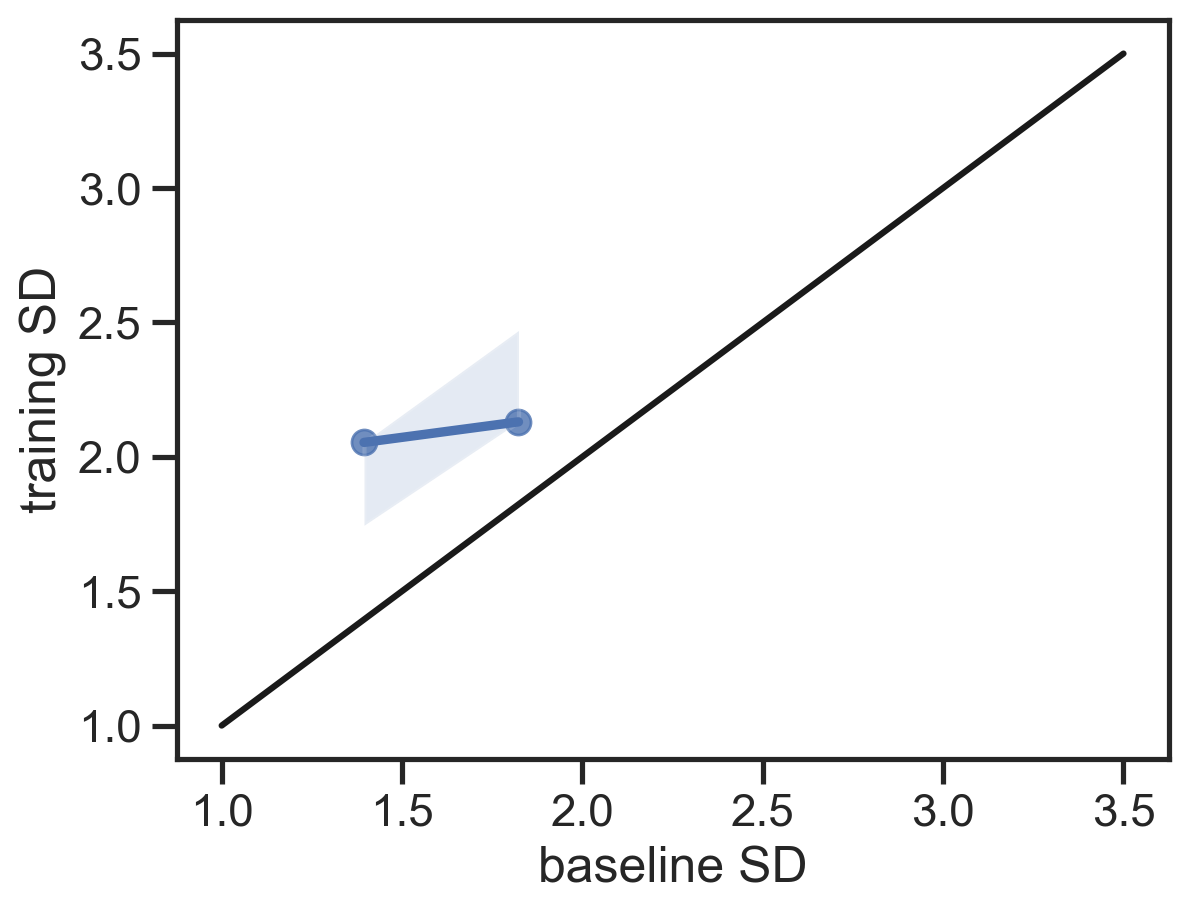

In [12]:
# Check if motor variability increases during perturbation block
var = pd.DataFrame({
    "sigma_motor_bsl":sigma_motor_bsl, 
    "sigma_motor_train":sigma_motor_train, 
    "sigma_v_train":sigma_v_train
})

fig, ax = plt.subplots()
ax.plot([1, 3.5], [1, 3.5], "k")
sns.regplot(data=var, x=sigma_motor_bsl, y=sigma_motor_train, ax=ax)
ax.set(xlabel="baseline SD", ylabel="training SD")
plt.show()

In [13]:
# Process data to create 5x5 IGE/EGE plots. Binning based on IGE.
adapt_rotation["ige_quintile"] = adapt_rotation.groupby(["SN", "rotation"])["theta_maxradv_clean"].transform(
    lambda x: pd.qcut(x, 5, labels=range(1, 6)))
adapt_jump["ige_quintile"] = adapt_jump.groupby(["SN", "tgt_error"])["theta_maxradv_clean"].transform(
    lambda x: pd.qcut(x, 5, labels=range(1, 6)))
rotation_binned = adapt_rotation.groupby(["SN", "rotation", "ige_quintile"])[["theta_maxradv_clean", "adaptation"]].mean().reset_index()
jump_binned = adapt_jump.groupby(["SN", "tgt_error", "ige_quintile"])[["theta_maxradv_clean", "adaptation"]].mean().reset_index()

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


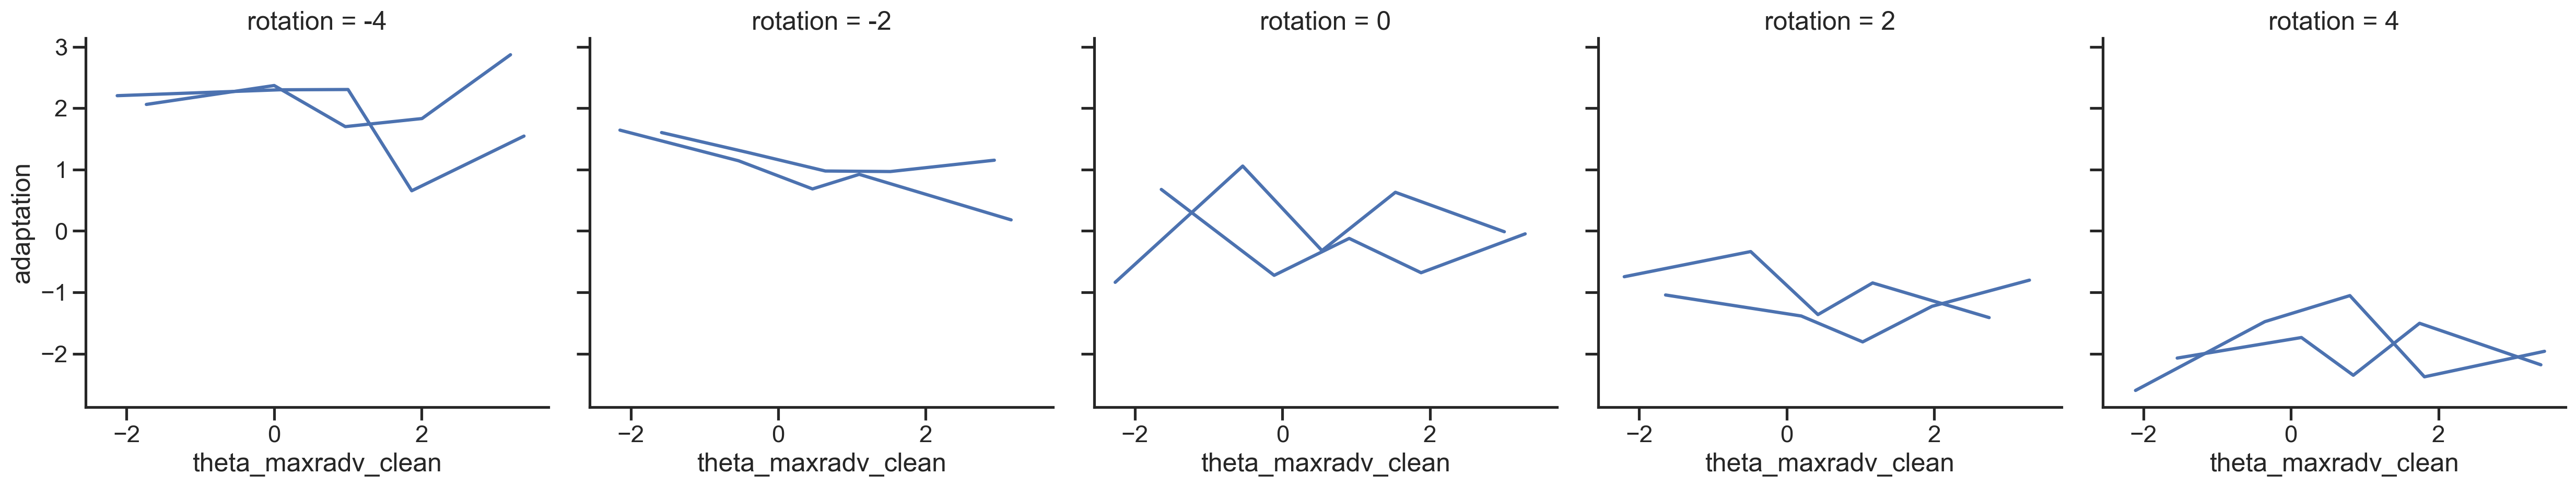

In [14]:
sns.relplot(data=rotation_binned, kind="line", x="theta_maxradv_clean", y="adaptation", units="SN",  col="rotation")

/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_50556/203418759.py:28: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=rotation_binned, x="rotation", y="adaptation", hue="ige_quintile", join=True, ax=ax2)


FileNotFoundError: [Errno 2] No such file or directory: 'images/group-data.png'

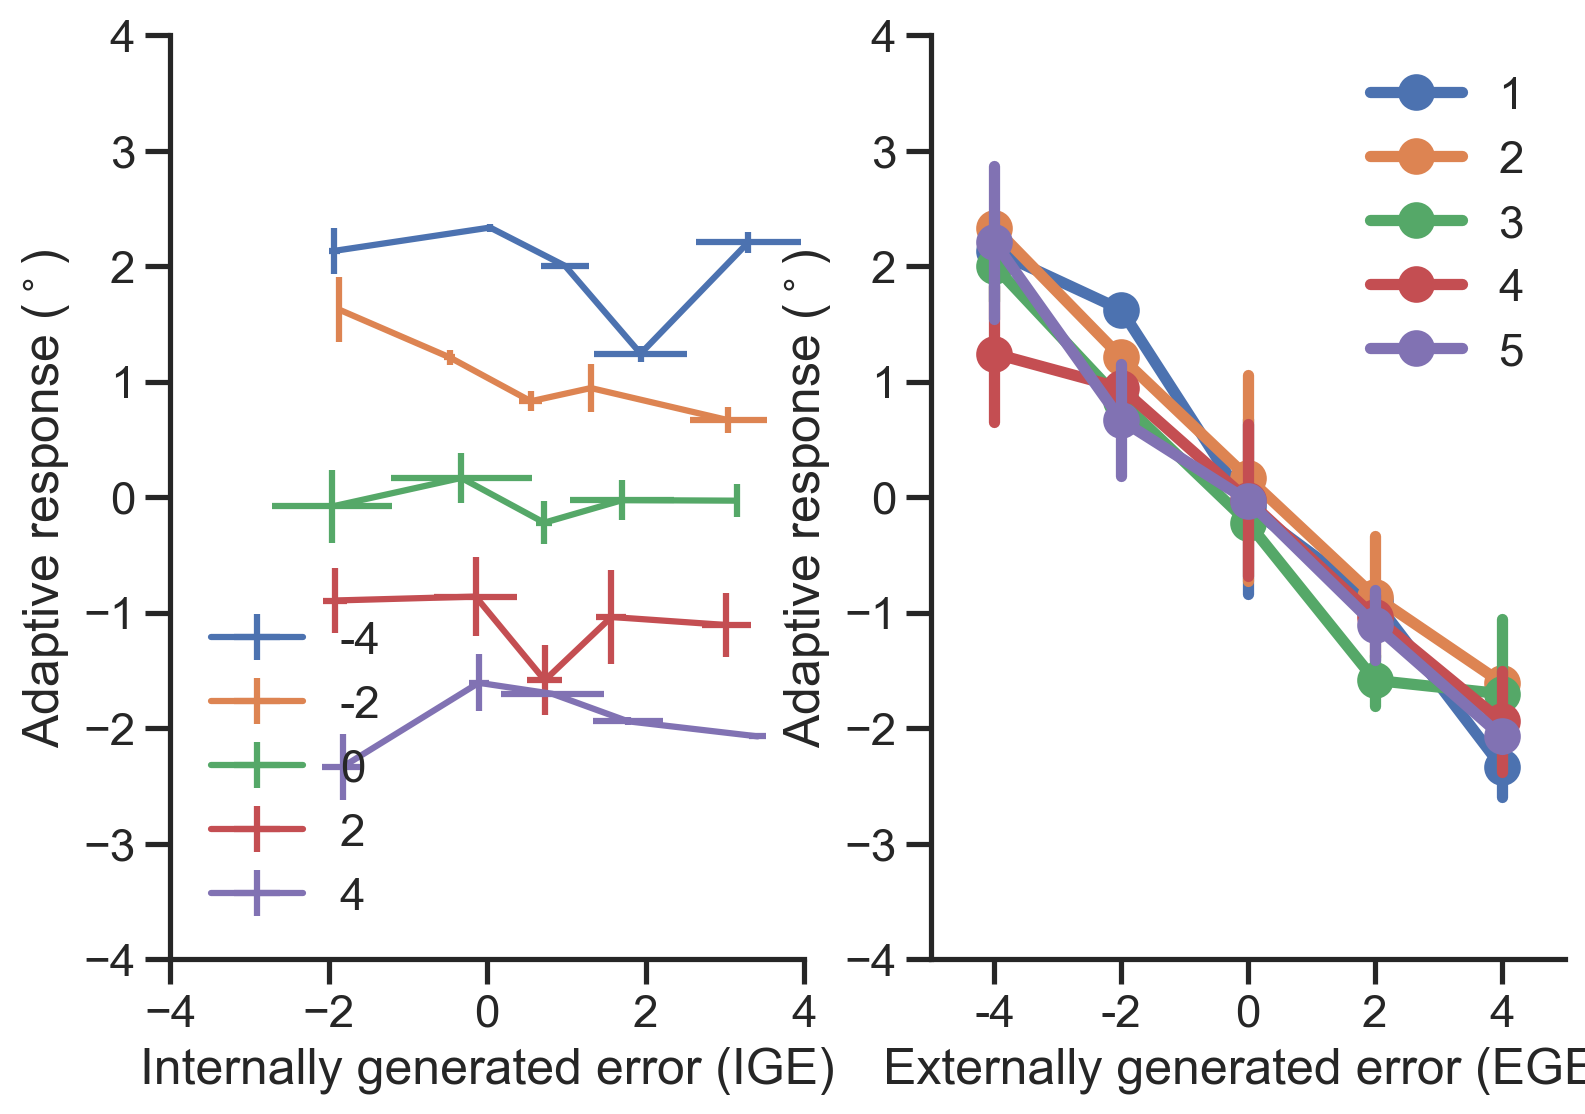

In [15]:
sns.set_theme("talk")
sns.set_style("ticks")

# Plot adaptive response vs IGE and EGE for rotation trials
perts = np.unique(rotation_binned["rotation"])
pert = []
x_mean_ige = np.zeros(5)
x_err_ige = np.zeros(5)
y_mean_ige = np.zeros(5)
y_err_ige = np.zeros(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
for i in range(len(perts)):
    idx = rotation_binned["rotation"] == perts[i]
    pert = pd.DataFrame(rotation_binned.loc[idx, :])
    for j in range(5):
        idx_bin = pert["ige_quintile"] == j + 1
        x_mean_ige[j] = pert.loc[idx_bin, "theta_maxradv_clean"].mean()
        x_err_ige[j] = pert.loc[idx_bin, "theta_maxradv_clean"].sem()
        y_mean_ige[j] = pert.loc[idx_bin, "adaptation"].mean()
        y_err_ige[j] = pert.loc[idx_bin, "adaptation"].sem()
    ax1.errorbar(x_mean_ige, y_mean_ige, x_err_ige, y_err_ige, label=perts[i])
ax1.legend(frameon=False)
ax1.set(xlabel="Internally generated error (IGE)", ylabel="Adaptive response ($^\circ$)", xlim=[-4, 4], ylim=[-4, 4])
sns.despine()

# Plot adaptive response as a function of EGE
sns.pointplot(data=rotation_binned, x="rotation", y="adaptation", hue="ige_quintile", join=True, ax=ax2)
ax2.set(xlabel="Externally generated error (EGE)", ylim=[-4, 4], ylabel="Adaptive response ($^\circ$)")
ax2.legend(frameon=False)
plt.savefig("images/group-data", dpi="figure")


In [ ]:
# Plot adaptive response vs IGE and EGE for rotation trials
perts = np.unique(jump_binned["tgt_error"])
pert = []
x_mean_ige = np.zeros(5)
x_err_ige = np.zeros(5)
y_mean_ige = np.zeros(5)
y_err_ige = np.zeros(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
for i in range(len(perts)):
    idx = jump_binned["tgt_error"] == perts[i]
    pert = pd.DataFrame(jump_binned.loc[idx, :])
    for j in range(5):
        idx_bin = pert["ige_quintile"] == j + 1
        x_mean_ige[j] = pert.loc[idx_bin, "theta_maxradv_clean"].mean()
        x_err_ige[j] = pert.loc[idx_bin, "theta_maxradv_clean"].sem()
        y_mean_ige[j] = pert.loc[idx_bin, "adaptation"].mean()
        y_err_ige[j] = pert.loc[idx_bin, "adaptation"].sem()
        
        x_mean_ige[j] = pert.loc[idx_bin, "theta_maxradv_clean"].mean()
        x_err_ige[j] = pert.loc[idx_bin, "theta_maxradv_clean"].sem()
        y_mean_ige[j] = pert.loc[idx_bin, "adaptation"].mean()
        y_err_ige[j] = pert.loc[idx_bin, "adaptation"].sem()
    ax1.errorbar(x_mean_ige, y_mean_ige, x_err_ige, y_err_ige, label=perts[i])
ax1.legend(frameon=False)
ax1.set(xlabel="Internally generated error (IGE)", ylabel="Adaptive response ($^\circ$)", xlim=[-4, 4], ylim=[-3, 3])
sns.despine()

# Plot adaptive response as a function of EGE
sns.pointplot(data=jump_binned, x="tgt_error", y="adaptation", hue="ige_quintile", join=True, ax=ax2)
ax2.set(xlabel="Externally generated error (EGE)", ylabel="Adaptive response ($^\circ$)", ylim=[-3, 3])
ax2.legend(frameon=False)
plt.show()

In [ ]:
# Median RTs
df.groupby("SN")[["RT", "MT"]].median().reset_index()